**Gathering Imports**


In [ ]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

**Dataloader**

In [ ]:
def get_dataloader(root_dir, train= True):
    mean, stdev= [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
    tnsfms= transforms.Compose([
        transforms.RandomCrop(32, padding= 4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, stdev)
    ])
    
    if not train:
        tnsfms= transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, stdev)
        ])
    
    dset= datasets.CIFAR10(root_dir, train= train, download= True, transform= tnsfms)
    dataloader= DataLoader(dset, batch_size= 32, shuffle= train, num_workers= 2)
    return dataloader

In [ ]:
train_loader= get_dataloader("/", train= True)
test_loader= get_dataloader("/", train= False)

Files already downloaded and verified
Files already downloaded and verified


**Xception Architecture**



> Conv-> BN-> ReLU block



In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride= 1, padding= 0, groups= 1, bias= False, use_norm= False, use_act= False):
        super(ConvBlock, self).__init__()
        self.use_norm= use_norm
        self.use_act= use_act
        self.conv= nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, groups= groups, bias= bias)
        self.bn= nn.BatchNorm2d(out_channels)
    def forward(self, x):
        x= self.conv(x)
        if self.use_norm:
            x= self.bn(x)
        if self.use_act:
            x= F.relu(x)
        return x



> Depthwise Seperable Convolution block


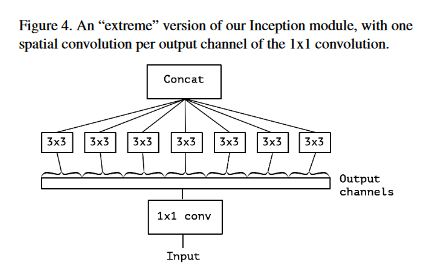



In [ ]:
class DepthwiseSepConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, use_act= False, pre_act= False, use_pool= False):
        super(DepthwiseSepConv, self).__init__()
        self.use_act= use_act
        self.pre_act= pre_act
        self.use_pool= use_pool

        self.conv1= ConvBlock(in_channels, in_channels, kernel_size, 1, padding, in_channels, bias= True)
        self.conv2= ConvBlock(in_channels, out_channels, 1, use_norm= True)
    def forward(self, x):
        if self.use_act and self.pre_act:
            x= F.relu(x)
        x= self.conv1(x)
        x= self.conv2(x)
        if self.use_act and not self.pre_act:
            x= F.relu(x)
        if self.use_pool:
            x= F.max_pool2d(x, 3, 2, 1)
        return x




> Entry Flow in Xception

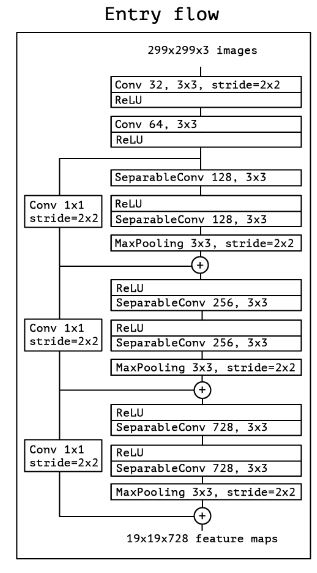



In [ ]:
class EntryFlow(nn.Module):
    def __init__(self):
        super(EntryFlow, self).__init__()
        channels= 32
        self.conv1_1= ConvBlock(3, channels, 3, 1, 1, use_norm= True, use_act= True)
        self.conv1_2= ConvBlock(channels, 2*channels, 3, 1, 1, use_norm= True, use_act= True)
        
        self.dsc1_1= DepthwiseSepConv(2*channels, 4*channels, 3, 1, use_act= True)
        self.dsc1_2= DepthwiseSepConv(4*channels, 4*channels, 3, 1, use_pool= True)
        self.skip1= ConvBlock(2*channels, 4*channels, 1, 2, use_norm= True)
        
        self.dsc2_1= DepthwiseSepConv(4*channels, 8*channels, 3, 1, use_act= True, pre_act= True)
        self.dsc2_2= DepthwiseSepConv(8*channels, 8*channels, 3, 1, use_act= True, pre_act= True, use_pool= True)
        self.skip2= ConvBlock(4*channels, 8*channels, 1, 2, use_norm= True)
        
        self.dsc3_1= DepthwiseSepConv(8*channels, 728, 3, 1, use_act= True, pre_act= True)
        self.dsc3_2= DepthwiseSepConv(728, 728, 3, 1, use_act= True, pre_act= True, use_pool= True) #POOL SIZE IS DIFFERENT
        self.skip3= ConvBlock(8*channels, 728, 1, 2, use_norm= True)

    def forward(self, x):
        x= self.conv1_1(x)
        x= self.conv1_2(x)

        x1= self.dsc1_1(x)
        x1= self.dsc1_2(x1)
        x1_res= self.skip1(x)
        x1+= x1_res
        
        x2= self.dsc2_1(x1)
        x2= self.dsc2_2(x2)
        
        x2_res= self.skip2(x1)
        
        x2+= x2_res

        x3= self.dsc3_1(x2)
        x3= self.dsc3_2(x3)
        
        x3_res= self.skip3(x2)
        
        x3+= x3_res

        return x3



> Middle Flow in Xception

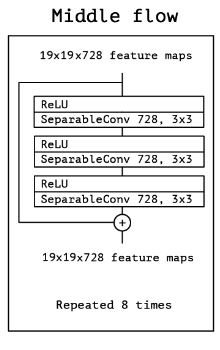


In [ ]:
class MiddleBlock(nn.Module):
    def __init__(self):
        super(MiddleBlock, self).__init__()
        self.dsc_1= DepthwiseSepConv(728, 728, 3, 1, use_act= True, pre_act= True)
        self.dsc_2= DepthwiseSepConv(728, 728, 3, 1, use_act= True, pre_act= True)
        self.dsc_3= DepthwiseSepConv(728, 728, 3, 1, use_act= True, pre_act= True)
    def forward(self, x):
        inputs= x
        x= self.dsc_1(x)
        x= self.dsc_2(x)
        x= self.dsc_3(x)
        x+= inputs
        return x

class MiddleFlow(nn.Module):
    def __init__(self):
        super(MiddleFlow, self).__init__()
        self.net= self.make_layers(8)

    def forward(self, x):
        return self.net(x)
        
    def make_layers(self, n_blocks):
        layers= []
        for b in range(n_blocks):
            block= MiddleBlock()
            layers.append(block)
        return nn.Sequential(*layers)



> Exit Flow in Xception

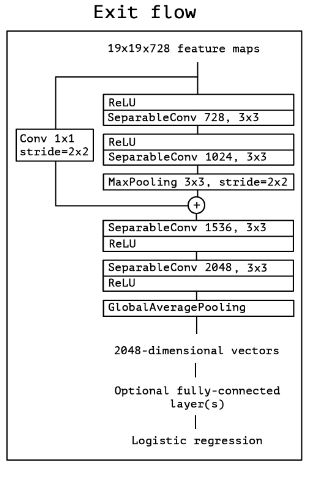



In [ ]:
class ExitFlow(nn.Module):
    def __init__(self):
        super(ExitFlow, self).__init__()
        self.dsc1_1= DepthwiseSepConv(728, 728, 3, 1, use_act= True, pre_act= True)
        self.dsc1_2= DepthwiseSepConv(728, 1024, 3, 1, use_act= True, pre_act= True, use_pool= True)
        self.skip1= ConvBlock(728, 1024, 1, 2)

        self.dsc2_1= DepthwiseSepConv(1024, 1536, 3, 1, use_act= True)
        self.dsc2_2= DepthwiseSepConv(1536, 2048, 3, 1, use_act= True)
    
    def forward(self, x):
        x1= self.dsc1_1(x)
        x1= self.dsc1_2(x1)
        
        x1_res= self.skip1(x)
        
        x1+= x1_res

        x2= self.dsc2_1(x1)
        x2= self.dsc2_2(x2)

        x= F.adaptive_avg_pool2d(x2, (1,1))
        return x

In [ ]:
class Xception(nn.Module):
    def __init__(self, n_classes=10):
        super(Xception, self).__init__()
        self.entryFlow= EntryFlow()
        self.middleFlow= MiddleFlow()
        self.exitFlow= ExitFlow()
        self.fc= nn.Linear(2048, n_classes)

    def forward(self, x):
        x= self.entryFlow(x)
        x= self.middleFlow(x)
        x= self.exitFlow(x)
        x= x.view(x.size(0), -1)
        x= self.fc(x)
        return x

In [ ]:
model= Xception().cuda()

**Training and Validation Stage**

In [ ]:
optimizer= optim.Adam(model.parameters(), lr= 1e-2)
loss_fn= nn.CrossEntropyLoss().cuda()

In [ ]:
for epoch in range(50):
    running_loss= 0
    validation_loss= 0
    model.train()
    print(f"Training epoch: {epoch+1}")
    for batch_ix, (imgs, targets) in enumerate(train_loader):
        imgs, targets= imgs.cuda(), targets.cuda()
        outs= model(imgs)
        loss= loss_fn(outs, targets)
        running_loss+= loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Train loss: {running_loss/len(train_loader)}")
    model.eval()
    for batch_ix, (imgs, targets) in enumerate(test_loader):
        imgs, targets= imgs.cuda(), targets.cuda()
        outs= model(imgs)
        with torch.no_grad():
            loss= loss_fn(outs, targets)
        validation_loss+= loss.item()
    print(f"Validation loss: {validation_loss/len(test_loader)}")
    torch.save(model.state_dict(), f"{epoch+1}.pth")
    print("Checkpoint saved\n\n")

Training epoch: 1
Train loss: 1.3644062006084567
Validation loss: 1.1234205348042254
Checkpoint saved


Training epoch: 2
Train loss: 1.0003473853462412
Validation loss: 0.9276489895372726
Checkpoint saved


Training epoch: 3
Train loss: 0.8176582731921476
Validation loss: 0.836513709336424
Checkpoint saved


Training epoch: 4
Train loss: 0.7066836704143102
Validation loss: 0.6363405111593942
Checkpoint saved


Training epoch: 5
Train loss: 0.6257084388040383
Validation loss: 0.5524789433176525
Checkpoint saved


Training epoch: 6
Train loss: 0.5620534310471302
Validation loss: 0.5983049036881414
Checkpoint saved


Training epoch: 7
Train loss: 0.5114071611803613
Validation loss: 0.4999289369811646
Checkpoint saved


Training epoch: 8
Train loss: 0.47198632755152936
Validation loss: 0.43319627185599113
Checkpoint saved


Training epoch: 9
Train loss: 0.4394924408891456
Validation loss: 0.5365050798311782
Checkpoint saved


Training epoch: 10
Train loss: 0.41136075762205987
Validation l